## <span style='color:DarkOliveGreen'>GA(supervised)<span style='color:DarkOliveGreen'>

### &emsp;&emsp; * <span style='color:white'>fun<span style='color:white'>

####  &emsp;  &emsp; -GA

#####  &emsp;  &emsp;  &emsp; &emsp;  --record

In [36]:
# record 
def on_generation(ga):
    print("Generation", ga.generations_completed)
    print(ga.population)
    
def on_fitness(ga, population_fitness):
    avg = sum(ga_instance.last_generation_fitness)/len(ga_instance.last_generation_fitness)
    maximul = max(ga_instance.last_generation_fitness)
    ft_iteration_avg.append(avg)
    ft_iteration_best.append(maximul)
    if ft_so_far_the_best:
        if max(ft_so_far_the_best)<=maximul:ft_so_far_the_best.append(maximul)
        else:ft_so_far_the_best.append(ft_so_far_the_best[-1])
    else:ft_so_far_the_best.append(maximul)

#####  &emsp;  &emsp;  &emsp; &emsp;  --crossover

In [37]:
# crossover
def order_crossover(parents, offspring_size, ga_instance):
    offspring = []
    idx = 0
    while len(offspring) != offspring_size[0]:
        p1 = list(parents[idx % parents.shape[0], :].copy())
        p2 = list(parents[(idx + 1) % parents.shape[0], :].copy())
        
        cut_pt = sorted(sample(p1,2))
        p1_ele = [p1[e] for e in range(cut_pt[0],cut_pt[1]+1)]
        p2_ele = [p for p in p2 if p not in p1_ele]

        offspring.append(p2_ele[0:cut_pt[0]]+p1_ele+p2_ele[cut_pt[0]:])
        idx += 1
    return np.array(offspring)

def position_based_crossover(parents, offspring_size, ga_instance):
    offspring = []
    idx = 0
    while len(offspring) != offspring_size[0]:
        p1 = list(parents[idx % parents.shape[0], :].copy())
        p2 = list(parents[(idx + 1) % parents.shape[0], :].copy())
        
        cut_pts = sorted(sample(p1,sample(p1,1)[0]))
        p1_ele = [p1[e] for e in cut_pts]
        p2_ele = [p for p in p2 if p not in p1_ele]
        
        c,e=[],0
        for i in cut_pts:
            c,e = p2_ele.insert(i,p1_ele[e]),e+1
            
        offspring.append(p2_ele)
        idx += 1

    return np.array(offspring)

#####  &emsp;  &emsp;  &emsp; &emsp;  --mutation

In [38]:
# mutation
def swap_mutation(offspring, ga_instance):
    for chromosome_idx in range(offspring.shape[0]):
        c = list(offspring[chromosome_idx])
        mut_pt = sorted(sample(c,2))
        c[mut_pt[0]], c[mut_pt[1]] = c[mut_pt[1]], c[mut_pt[0]]
        offspring[chromosome_idx] = np.array(c)
    return offspring

def scramble_mutation(offspring, ga_instance):
    for chromosome_idx in range(offspring.shape[0]):
        c = list(offspring[chromosome_idx])
        cut_pt = sorted(sample(c,2))
        scrable_ele = c[cut_pt[0]:cut_pt[1]+1]
        offspring[chromosome_idx] = np.array(c[0:cut_pt[0]]+sample(scrable_ele,len(scrable_ele))+c[cut_pt[1]+1:])
    return offspring

#####  &emsp;  &emsp;  &emsp; &emsp;  --fittness

In [39]:
# fittness

def min_type1_dis_fitness(solution, solution_idx): # need df_1 and l_col
    n_data = []
    n_oreder = [l_col[i] for i in solution]
    df_new = df_1[n_oreder]
    for r in range(0,len(df_1)):
        # df_1.iloc[r,:]
        n_data.append(encode_category(df_new.iloc[r,:]))
    return -mean_squared_error(n_data, [sum(n_data)/len(n_data)]*len(n_data))

def max_ssb_ssw_fitness(solution, solution_idx):
    X,Y = [],[]
    n_oreder = [l_col[i] for i in solution]
    df_0_new = df_0[n_oreder]
    df_1_new = df_1[n_oreder]
    for r in range(0,len(df_0)):
        X.append(encode_category(df_0_new.iloc[r,:]))
    for r in range(0,len(df_1)):
        Y.append(encode_category(df_1_new.iloc[r,:]))
    SST = sum([(t - np.mean(X+Y))**2 for t in X+Y])
    SSE = sum([(x - np.mean(X))**2 for x in X])+sum([(y - np.mean(Y))**2 for y in Y])
    SSB = SST-SSE
    return SSB/SSE

####  &emsp;  &emsp; -plot

In [40]:
def plot_GA_evolve(ft_iteration_best,ft_so_far_the_best,ft_iteration_avg):
    # Create traces
    x = [i for i in range(1,num_generations+1)]
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=x, y=ft_iteration_best,
                        mode='lines',name='iteration the best'))
    fig.add_trace(go.Scatter(x=x, y=ft_so_far_the_best,
                        mode='lines',name='so far the best'))
    fig.add_trace(go.Scatter(x=x, y=ft_iteration_avg,
                        mode='lines', name='iteration average'))
    fig.update_layout(title="Binary column permutation",xaxis_title="Generation",yaxis_title="Fitness",
                      legend=dict(orientation="h",yanchor="bottom",y=1.02,xanchor="right",x=1))
    return fig
# fig.show()

In [41]:
def arrange_col_by_order(df_bin, order):
    n_data = []
    n_oreder = list(order)
    df_new = df_bin.copy()[n_oreder]
    for r in range(0,len(df_bin)):
        n_data.append(encode_category(df_new.iloc[r,:]))
    df_new = pd.DataFrame(n_data)
    df_new["GB"] = df_bin.GB
    return df_new

def get_cumulated_points(df):
    ordered_dict = collections.OrderedDict(sorted(Counter(df[df.columns[0]]).items()))
    x,y = [],[]
    cum = 0
    for c in ordered_dict:
        cum+=ordered_dict[c]
        x.append(c)
        y.append(cum)
    new_y = []
    for o in y:
        if o and max(y)!=0: new_y.append(o/max(y))
        else:new_y.append(0)
    return x,new_y

def plot_encode_axis(df, name):
    fig = make_subplots(rows=2, cols=1, shared_xaxes='all')#, column_widths=[0.7, 0.3])
    df_1 = df.loc[df.GB==1]
    df_0 = df.loc[df.GB==0]
    x1,y1 = get_cumulated_points(df_1)
    x0,y0 = get_cumulated_points(df_0)

    fig.add_trace(go.Scatter(x=df_0[df.columns[0]],y=len(df_0)*[f"GB=0"],mode='markers', marker=dict(color="blue"),
                             name=f"GB=0, [{len(df_0)}]",),row=1, col=1)
    fig.add_trace(go.Scatter(x=df_1[df.columns[0]],y=len(df_1)*["GB=1"],mode='markers', marker=dict(color="red"),
                             name=f"GB=1, [{len(df_1)}]",),row=1, col=1)

    fig.add_trace(go.Scatter(x=x1, y=y1,mode='lines',marker_color='red',name='cum 1')
                  ,row=2, col=1)
    fig.add_trace(go.Scatter(x=x0, y=y0,mode='lines',marker_color='blue',name='cum 2')
                  ,row=2, col=1)

    for trace in fig['data']: 
        if("cum" in trace['name']): trace['showlegend'] = False
    fig.update_layout(title=f"Encoding result, {name}",xaxis2_title="Categorical variable",#yaxis_title="Type",
                      legend=dict(orientation="h",yanchor="bottom",y=1.02,xanchor="right",x=1))
    return fig

### &emsp;| (1) build GA model

In [42]:
# GA settings
num_genes = len(df_bin.columns[:-1])
init_range_low = 0
init_range_high = num_genes

num_generations = 30
sol_per_pop = 10

NameError: name 'df_bin' is not defined

In [43]:
# Dataframe para
df = df_bin
df_0 = df_bin.loc[df_bin.GB==0].copy()
df_1 = df_bin.loc[df_bin.GB==1].copy()
l_col = df_bin.columns[:-1].tolist()

NameError: name 'df_bin' is not defined

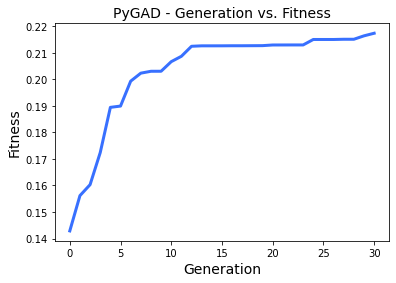

In [302]:
ft_iteration_avg = []
ft_iteration_best = []
ft_so_far_the_best = []

crossover_type = position_based_crossover
mutation_type = scramble_mutation
fitness_func = max_ssb_ssw_fitness

ga_instance = pygad.GA(num_generations=num_generations,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       
                       parent_selection_type="sss",
                       
                       crossover_type=crossover_type,
                       crossover_probability=0.8,
                       
                       mutation_type=mutation_type,
                       mutation_probability = 0.2,
                         
                       num_parents_mating=2,
                       fitness_func=fitness_func,
                       
                       gene_type=int,
                       gene_space=[i for i in range(init_range_low,init_range_high)],
                       
                       on_fitness = on_fitness,
                       allow_duplicate_genes=False,
                      )
ga_instance.run()
ga_instance.plot_result()
print()

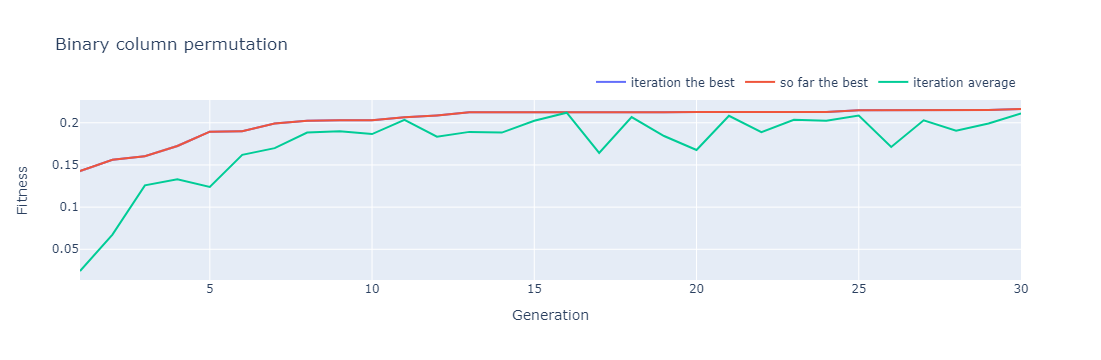

In [303]:
fig = plot_GA_evolve(ft_iteration_best,ft_so_far_the_best,ft_iteration_avg)
fig

In [92]:
fig.write_html(r"C:\Users\User\Desktop\Terry\Data\Output\3D Fig\GA evovle.html")

### &emsp;| (2) encoding result

In [607]:
df_ori = arrange_col_by_order(df_bin,df_bin.columns[:-1])
plot_encode_axis(df_ori, "(original sequence)")# df_new

NameError: name 'arrange_col_by_order' is not defined

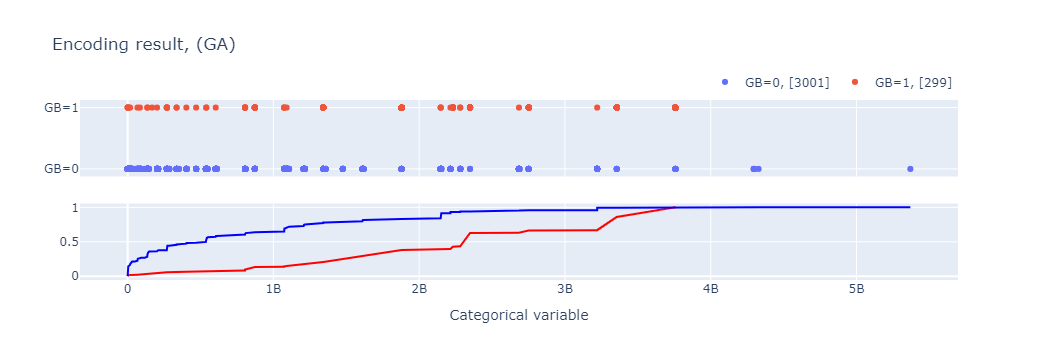

In [305]:
df_ga = arrange_col_by_order(df_bin,[l_col[i] for i in list(ga_instance.best_solution()[0])])
plot_encode_axis(df_ga, "(GA)")

In [ ]:
## <span style='color:DarkOliveGreen'>GA(supervised)<span style='color:DarkOliveGreen'>

### &emsp;&emsp; * <span style='color:white'>fun<span style='color:white'>

####  &emsp;  &emsp; -GA

#####  &emsp;  &emsp;  &emsp; &emsp;  --record

# record 
def on_generation(ga):
    print("Generation", ga.generations_completed)
    print(ga.population)
    
def on_fitness(ga, population_fitness):
    avg = sum(ga_instance.last_generation_fitness)/len(ga_instance.last_generation_fitness)
    maximul = max(ga_instance.last_generation_fitness)
    ft_iteration_avg.append(avg)
    ft_iteration_best.append(maximul)
    if ft_so_far_the_best:
        if max(ft_so_far_the_best)<=maximul:ft_so_far_the_best.append(maximul)
        else:ft_so_far_the_best.append(ft_so_far_the_best[-1])
    else:ft_so_far_the_best.append(maximul)

#####  &emsp;  &emsp;  &emsp; &emsp;  --crossover

# crossover
def order_crossover(parents, offspring_size, ga_instance):
    offspring = []
    idx = 0
    while len(offspring) != offspring_size[0]:
        p1 = list(parents[idx % parents.shape[0], :].copy())
        p2 = list(parents[(idx + 1) % parents.shape[0], :].copy())
        
        cut_pt = sorted(sample(p1,2))
        p1_ele = [p1[e] for e in range(cut_pt[0],cut_pt[1]+1)]
        p2_ele = [p for p in p2 if p not in p1_ele]

        offspring.append(p2_ele[0:cut_pt[0]]+p1_ele+p2_ele[cut_pt[0]:])
        idx += 1
    return np.array(offspring)

def position_based_crossover(parents, offspring_size, ga_instance):
    offspring = []
    idx = 0
    while len(offspring) != offspring_size[0]:
        p1 = list(parents[idx % parents.shape[0], :].copy())
        p2 = list(parents[(idx + 1) % parents.shape[0], :].copy())
        
        cut_pts = sorted(sample(p1,sample(p1,1)[0]))
        p1_ele = [p1[e] for e in cut_pts]
        p2_ele = [p for p in p2 if p not in p1_ele]
        
        c,e=[],0
        for i in cut_pts:
            c,e = p2_ele.insert(i,p1_ele[e]),e+1
            
        offspring.append(p2_ele)
        idx += 1

    return np.array(offspring)

#####  &emsp;  &emsp;  &emsp; &emsp;  --mutation

# mutation
def swap_mutation(offspring, ga_instance):
    for chromosome_idx in range(offspring.shape[0]):
        c = list(offspring[chromosome_idx])
        mut_pt = sorted(sample(c,2))
        c[mut_pt[0]], c[mut_pt[1]] = c[mut_pt[1]], c[mut_pt[0]]
        offspring[chromosome_idx] = np.array(c)
    return offspring

def scramble_mutation(offspring, ga_instance):
    for chromosome_idx in range(offspring.shape[0]):
        c = list(offspring[chromosome_idx])
        cut_pt = sorted(sample(c,2))
        scrable_ele = c[cut_pt[0]:cut_pt[1]+1]
        offspring[chromosome_idx] = np.array(c[0:cut_pt[0]]+sample(scrable_ele,len(scrable_ele))+c[cut_pt[1]+1:])
    return offspring

#####  &emsp;  &emsp;  &emsp; &emsp;  --fittness

# fittness

def min_type1_dis_fitness(solution, solution_idx): # need df_1 and l_col
    n_data = []
    n_oreder = [l_col[i] for i in solution]
    df_new = df_1[n_oreder]
    for r in range(0,len(df_1)):
        # df_1.iloc[r,:]
        n_data.append(encode_category(df_new.iloc[r,:]))
    return -mean_squared_error(n_data, [sum(n_data)/len(n_data)]*len(n_data))

def max_ssb_ssw_fitness(solution, solution_idx):
    X,Y = [],[]
    n_oreder = [l_col[i] for i in solution]
    df_0_new = df_0[n_oreder]
    df_1_new = df_1[n_oreder]
    for r in range(0,len(df_0)):
        X.append(encode_category(df_0_new.iloc[r,:]))
    for r in range(0,len(df_1)):
        Y.append(encode_category(df_1_new.iloc[r,:]))
    SST = sum([(t - np.mean(X+Y))**2 for t in X+Y])
    SSE = sum([(x - np.mean(X))**2 for x in X])+sum([(y - np.mean(Y))**2 for y in Y])
    SSB = SST-SSE
    return SSB/SSE

####  &emsp;  &emsp; -plot

def plot_GA_evolve(ft_iteration_best,ft_so_far_the_best,ft_iteration_avg):
    # Create traces
    x = [i for i in range(1,num_generations+1)]
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=x, y=ft_iteration_best,
                        mode='lines',name='iteration the best'))
    fig.add_trace(go.Scatter(x=x, y=ft_so_far_the_best,
                        mode='lines',name='so far the best'))
    fig.add_trace(go.Scatter(x=x, y=ft_iteration_avg,
                        mode='lines', name='iteration average'))
    fig.update_layout(title="Binary column permutation",xaxis_title="Generation",yaxis_title="Fitness",
                      legend=dict(orientation="h",yanchor="bottom",y=1.02,xanchor="right",x=1))
    return fig
# fig.show()

def arrange_col_by_order(df_bin, order):
    n_data = []
    n_oreder = list(order)
    df_new = df_bin.copy()[n_oreder]
    for r in range(0,len(df_bin)):
        n_data.append(encode_category(df_new.iloc[r,:]))
    df_new = pd.DataFrame(n_data)
    df_new["GB"] = df_bin.GB
    return df_new

def get_cumulated_points(df):
    ordered_dict = collections.OrderedDict(sorted(Counter(df[df.columns[0]]).items()))
    x,y = [],[]
    cum = 0
    for c in ordered_dict:
        cum+=ordered_dict[c]
        x.append(c)
        y.append(cum)
    new_y = []
    for o in y:
        if o and max(y)!=0: new_y.append(o/max(y))
        else:new_y.append(0)
    return x,new_y

def plot_encode_axis(df, name):
    fig = make_subplots(rows=2, cols=1, shared_xaxes='all')#, column_widths=[0.7, 0.3])
    df_1 = df.loc[df.GB==1]
    df_0 = df.loc[df.GB==0]
    x1,y1 = get_cumulated_points(df_1)
    x0,y0 = get_cumulated_points(df_0)

    fig.add_trace(go.Scatter(x=df_0[df.columns[0]],y=len(df_0)*[f"GB=0"],mode='markers', marker=dict(color="blue"),
                             name=f"GB=0, [{len(df_0)}]",),row=1, col=1)
    fig.add_trace(go.Scatter(x=df_1[df.columns[0]],y=len(df_1)*["GB=1"],mode='markers', marker=dict(color="red"),
                             name=f"GB=1, [{len(df_1)}]",),row=1, col=1)

    fig.add_trace(go.Scatter(x=x1, y=y1,mode='lines',marker_color='red',name='cum 1')
                  ,row=2, col=1)
    fig.add_trace(go.Scatter(x=x0, y=y0,mode='lines',marker_color='blue',name='cum 2')
                  ,row=2, col=1)

    for trace in fig['data']: 
        if("cum" in trace['name']): trace['showlegend'] = False
    fig.update_layout(title=f"Encoding result, {name}",xaxis2_title="Categorical variable",#yaxis_title="Type",
                      legend=dict(orientation="h",yanchor="bottom",y=1.02,xanchor="right",x=1))
    return fig

### &emsp;| (1) build GA model

# GA settings
num_genes = len(df_bin.columns[:-1])
init_range_low = 0
init_range_high = num_genes

num_generations = 30
sol_per_pop = 10

# Dataframe para
df = df_bin
df_0 = df_bin.loc[df_bin.GB==0].copy()
df_1 = df_bin.loc[df_bin.GB==1].copy()
l_col = df_bin.columns[:-1].tolist()

ft_iteration_avg = []
ft_iteration_best = []
ft_so_far_the_best = []

crossover_type = position_based_crossover
mutation_type = scramble_mutation
fitness_func = max_ssb_ssw_fitness

ga_instance = pygad.GA(num_generations=num_generations,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       
                       parent_selection_type="sss",
                       
                       crossover_type=crossover_type,
                       crossover_probability=0.8,
                       
                       mutation_type=mutation_type,
                       mutation_probability = 0.2,
                         
                       num_parents_mating=2,
                       fitness_func=fitness_func,
                       
                       gene_type=int,
                       gene_space=[i for i in range(init_range_low,init_range_high)],
                       
                       on_fitness = on_fitness,
                       allow_duplicate_genes=False,
                      )
ga_instance.run()
ga_instance.plot_result()
print()

fig = plot_GA_evolve(ft_iteration_best,ft_so_far_the_best,ft_iteration_avg)
fig

fig.write_html(r"C:\Users\User\Desktop\Terry\Data\Output\3D Fig\GA evovle.html")

### &emsp;| (2) encoding result

df_ori = arrange_col_by_order(df_bin,df_bin.columns[:-1])
plot_encode_axis(df_ori, "(original sequence)")# df_new

df_ga = arrange_col_by_order(df_bin,[l_col[i] for i in list(ga_instance.best_solution()[0])])
plot_encode_axis(df_ga, "(GA)")